# CSC 215 - MiniProject 3
## Khoi Hoang

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
import scipy as sp
import math
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
from IPython.display import Markdown, display
from sklearn import metrics

%matplotlib inline

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# feature rank
def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

## Data Proprocessing
- Add columns labels to original data
- Remove irrelevant columns (all values are the same)
- Binary Classification - Encode good connection as 0, attack as 1

In [11]:
df = pd.read_csv('network_intrusion_data.csv')
df.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]

In [12]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [13]:
df.shape

(494020, 42)

In [14]:
# df = df.loc[:, (df != 0).any(axis=0)] #drop columns with all 0
unique_val = df.apply(pd.Series.nunique)
cols_to_drop = unique_val[unique_val==1].index
df = df.drop(cols_to_drop, axis=1)

In [15]:
df.shape

(494020, 40)

In [23]:
connection_type, count = np.unique(df['outcome'].values,return_counts=True)

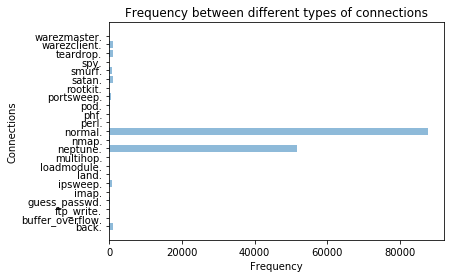

In [31]:
x_pos = np.arange(len(connection_type))
measurement = count

plt.barh(x_pos, measurement, align='center', alpha=0.5)
plt.ylabel('Connections')
plt.xlabel('Frequency')
plt.title('Frequency between different types of connections')
plt.yticks(x_pos, connection_type)

plt.show()

In [9]:
# binary encode the outcome, 0 is good/normal and 1 is an attack
df['outcome'] = df['outcome'].apply(lambda x: '0' if x == 'normal.' else '1')

In [10]:
np.unique(df['outcome'].values,return_counts=True)

(array(['0', '1'], dtype=object), array([ 97277, 396743]))

In [11]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [22]:
df.drop_duplicates(keep='first', inplace=True)

In [13]:
df.shape

(145584, 40)

In [14]:
np.unique(df['outcome'].values,return_counts=True)
#df.dtypes

(array(['0', '1'], dtype=object), array([87831, 57753], dtype=int64))

## Data normalization
- Normalize numeric data (int64, float64 type)
- Label encode symbolic data (object)

Data is now ready to be plugged into sklearn models!

In [15]:
scaler = preprocessing.StandardScaler()

cols_to_normalize = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = scaler.fit_transform(df.select_dtypes(include=['float64','int64']))

numeric_features = pd.DataFrame(numeric_features, columns=cols_to_normalize)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
numeric_features.shape

(145584, 36)

In [17]:
scaler = preprocessing.LabelEncoder()

cols_to_encode = df.select_dtypes(include=['object']).columns
label_features = df.select_dtypes(include=['object']).apply(scaler.fit_transform)

label_features = pd.DataFrame(label_features, columns=cols_to_encode)

In [18]:
label_features.head()

,protocol_type,service,flag,outcome
0,1,22,9,0
1,1,22,9,0
2,1,22,9,0
3,1,22,9,0
4,1,22,9,0


In [19]:
label_features.drop(columns=['outcome'], inplace=True)

In [20]:
label_features.shape

(145584, 3)

In [21]:
numeric_features.reset_index(drop=True, inplace=True)
label_features.reset_index(drop=True, inplace=True)
input_data = pd.concat([numeric_features, label_features], axis=1)
input_data.shape

(145584, 39)

In [22]:
output_data = df['outcome']
output_data.shape

(145584,)

# Sklearn models

In [23]:
# split into train/test set
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=43)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Initiate and train all the models
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train, y_train)

svc = LinearSVC(dual=False)
svc.fit(x_train, y_train)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

-----------------**Logistic Regression Report**---------------

F1 score: 0.9879291734906172
Confusion matrix: 
 [[21785   157]
 [  282 14172]]
Plotting confusion matrix


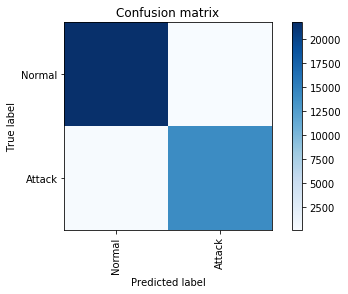

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21942
           1       0.99      0.98      0.98     14454

   micro avg       0.99      0.99      0.99     36396
   macro avg       0.99      0.99      0.99     36396
weighted avg       0.99      0.99      0.99     36396



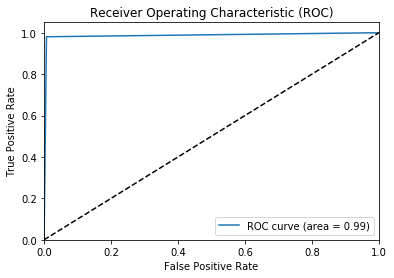

In [25]:
y_pred_Logistic = logreg.predict(x_test)
logistic_f1 = metrics.f1_score(y_test, y_pred_Logistic, average= "weighted")
logistic_cm = confusion_matrix(y_test, y_pred_Logistic)
printmd("-----------------**Logistic Regression Report**---------------")
print("F1 score: {}".format(logistic_f1))
print("Confusion matrix: \n", logistic_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(logistic_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_Logistic))

plot_roc(y_pred_Logistic.astype(np.int), y_test.astype(np.int))

In [26]:
y_pred_Logistic.astype(np.int)

array([1, 0, 0, ..., 0, 1, 0])

-----------------**SVM Report**---------------

F1 score: 0.9845662371075575
Confusion matrix: 
 [[21768   174]
 [  387 14067]]
Plotting confusion matrix


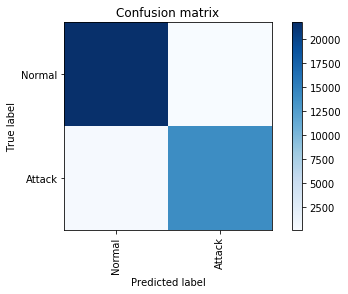

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     21942
           1       0.99      0.97      0.98     14454

   micro avg       0.98      0.98      0.98     36396
   macro avg       0.99      0.98      0.98     36396
weighted avg       0.98      0.98      0.98     36396



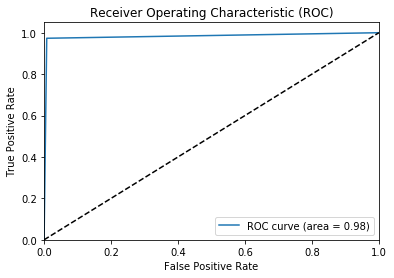

In [27]:
y_pred_svc = svc.predict(x_test)
svc_f1 = metrics.f1_score(y_test, y_pred_svc, average= "weighted")
svc_cm = confusion_matrix(y_test, y_pred_svc)
printmd("-----------------**SVM Report**---------------")
print("F1 score: {}".format(svc_f1))
print("Confusion matrix: \n", svc_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(svc_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_svc))

plot_roc(y_pred_svc.astype(np.int), y_test.astype(np.int))

-----------------**KNN Report**---------------

F1 score: 0.9976089597579206
Confusion matrix: 
 [[21922    20]
 [   67 14387]]
Plotting confusion matrix


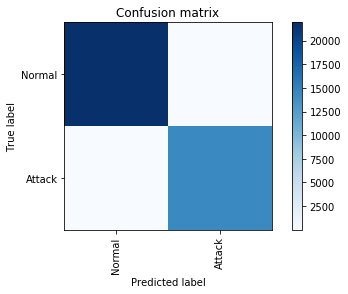

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21942
           1       1.00      1.00      1.00     14454

   micro avg       1.00      1.00      1.00     36396
   macro avg       1.00      1.00      1.00     36396
weighted avg       1.00      1.00      1.00     36396



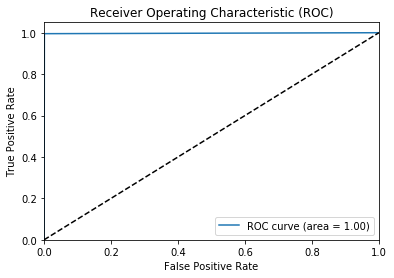

In [28]:
y_pred_knn = knn.predict(x_test)
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_cm = confusion_matrix(y_test, y_pred_knn)
printmd("-----------------**KNN Report**---------------")
print("F1 score: {}".format(knn_f1))
print("Confusion matrix: \n", knn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(knn_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_knn))

plot_roc(y_pred_knn.astype(np.int), y_test.astype(np.int))

-----------------**Gaussian Naive Bayes Report**---------------

F1 score: 0.9745197538076749
Confusion matrix: 
 [[21685   257]
 [  668 13786]]
Plotting confusion matrix


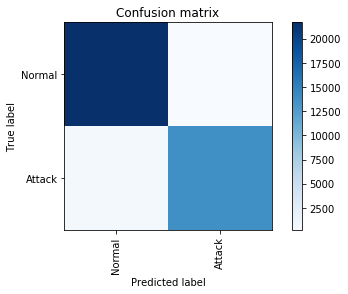

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     21942
           1       0.98      0.95      0.97     14454

   micro avg       0.97      0.97      0.97     36396
   macro avg       0.98      0.97      0.97     36396
weighted avg       0.97      0.97      0.97     36396



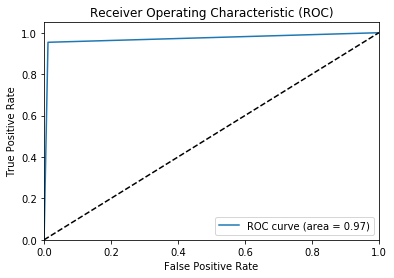

In [29]:
y_pred_gnb = gnb.predict(x_test)
gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average= "weighted")
gnb_cm = confusion_matrix(y_test, y_pred_gnb)
printmd("-----------------**Gaussian Naive Bayes Report**---------------")
print("F1 score: {}".format(gnb_f1))
print("Confusion matrix: \n", gnb_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(gnb_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_gnb))

plot_roc(y_pred_gnb.astype(np.int), y_test.astype(np.int))

# Fully Connected Neural Network model

Output need to be one hot encode before applying the model

In [30]:
scaler = preprocessing.LabelEncoder()
output_tf = scaler.fit_transform(df['outcome'])
output_tf

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
output_tf.shape

(145584,)

In [32]:
tf_data = input_data.copy()
tf_data['outcome'] = output_tf
tf_data.shape

(145584, 40)

In [33]:
x, y = to_xy(tf_data, 'outcome')

In [34]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

Using TensorFlow backend.


In [36]:
checkpointer = ModelCheckpoint(filepath=".\classification.hdf5", verbose=0, save_best_only=True) # save best model
activation_func = ['relu', 'tanh']
optimizer_func = ['adam', 'sgd']

for i in range(2):
    for j in range(2):
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        #Build network
        model = Sequential()

        model.add(Dense(128, input_dim=x_train_tf.shape[1], activation=activation_func[i])) # Hidden 1     #  why input_dim=x.shape[1]?  
        model.add(Dropout(0.27))
        model.add(Dense(64, activation=activation_func[i])) # Hidden 2
        model.add(Dropout(0.27))
        model.add(Dense(32, activation=activation_func[i])) # Hidden 4
        model.add(Dense(y_train_tf.shape[1], activation='softmax')) # Output

        model.compile(loss='categorical_crossentropy', optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=1,epochs=1000, batch_size=512, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\classification.hdf5') # load weights from best model

**Activation** = relu  **Optimizer** = adam 

Train on 109188 samples, validate on 36396 samples
Epoch 1/1000
109188/109188 [==============================] - 3s 30us/step - loss: 0.2138 - acc: 0.9206 - val_loss: 0.0573 - val_acc: 0.9841
Epoch 2/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0546 - acc: 0.9838 - val_loss: 0.0298 - val_acc: 0.9887
Epoch 3/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0331 - acc: 0.9891 - val_loss: 0.0175 - val_acc: 0.9955
Epoch 4/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0228 - acc: 0.9931 - val_loss: 0.0148 - val_acc: 0.9959
Epoch 5/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0190 - acc: 0.9943 - val_loss: 0.0143 - val_acc: 0.9960
Epoch 6/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0167 - acc: 0.9953 - val_loss: 0.0127 - val_acc: 0.9965
Epoch 7/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0148 - acc: 0.9959

**Activation** = relu  **Optimizer** = sgd 

Train on 109188 samples, validate on 36396 samples
Epoch 1/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.3283 - acc: 0.8760 - val_loss: 0.1228 - val_acc: 0.9691
Epoch 2/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1452 - acc: 0.9587 - val_loss: 0.1019 - val_acc: 0.9756
Epoch 3/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1176 - acc: 0.9683 - val_loss: 0.0910 - val_acc: 0.9768
Epoch 4/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1038 - acc: 0.9722 - val_loss: 0.0836 - val_acc: 0.9777
Epoch 5/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.0944 - acc: 0.9744 - val_loss: 0.0777 - val_acc: 0.9802
Epoch 6/1000
109188/109188 [==============================] - 1s 8us/step - loss: 0.0889 - acc: 0.9766 - val_loss: 0.0732 - val_acc: 0.9811
Epoch 7/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.0824 - acc: 0.9784 - val

**Activation** = tanh  **Optimizer** = adam 

Train on 109188 samples, validate on 36396 samples
Epoch 1/1000
109188/109188 [==============================] - 2s 15us/step - loss: 0.0977 - acc: 0.9662 - val_loss: 0.0247 - val_acc: 0.9925
Epoch 2/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0251 - acc: 0.9919 - val_loss: 0.0183 - val_acc: 0.9950
Epoch 3/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0199 - acc: 0.9940 - val_loss: 0.0149 - val_acc: 0.9960
Epoch 4/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0172 - acc: 0.9950 - val_loss: 0.0148 - val_acc: 0.9959
Epoch 5/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0159 - acc: 0.9954 - val_loss: 0.0130 - val_acc: 0.9962
Epoch 6/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0151 - acc: 0.9956 - val_loss: 0.0129 - val_acc: 0.9961
Epoch 7/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0128 - acc: 0.9964

**Activation** = tanh  **Optimizer** = sgd 

Train on 109188 samples, validate on 36396 samples
Epoch 1/1000
109188/109188 [==============================] - 1s 13us/step - loss: 0.2514 - acc: 0.9121 - val_loss: 0.1191 - val_acc: 0.9685
Epoch 2/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1314 - acc: 0.9651 - val_loss: 0.1045 - val_acc: 0.9758
Epoch 3/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1119 - acc: 0.9700 - val_loss: 0.0927 - val_acc: 0.9760
Epoch 4/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.0999 - acc: 0.9736 - val_loss: 0.0869 - val_acc: 0.9776
Epoch 5/1000
109188/109188 [==============================] - 1s 8us/step - loss: 0.0918 - acc: 0.9757 - val_loss: 0.0813 - val_acc: 0.9807
Epoch 6/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.0871 - acc: 0.9770 - val_loss: 0.0766 - val_acc: 0.9813
Epoch 7/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.0824 - acc: 0.9784 - val

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 66        
Total params: 15,522
Trainable params: 15,522
Non-trainable params: 0
_________________________________________________________________


-----------------**Fully-Connected Neural Network Report**---------------

F1 score: 0.9756289115611285
Confusion matrix: 
 [[21593   349]
 [  537 13917]]
Plotting confusion matrix


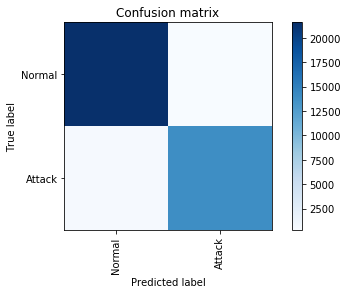

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21942
           1       0.98      0.96      0.97     14454

   micro avg       0.98      0.98      0.98     36396
   macro avg       0.98      0.97      0.97     36396
weighted avg       0.98      0.98      0.98     36396



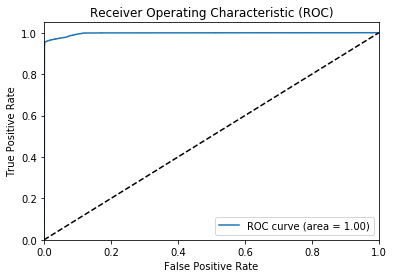

In [38]:
nn_pred = model.predict(x_test_tf)
nn_pred = np.argmax(nn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

nn_f1 = metrics.f1_score(y_true, nn_pred, average= "weighted")
nn_cm = confusion_matrix(y_true, nn_pred)
printmd("-----------------**Fully-Connected Neural Network Report**---------------")
print("F1 score: {}".format(nn_f1))
print("Confusion matrix: \n", nn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(nn_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_true, nn_pred))

nn_pred = model.predict(x_test_tf)
nn_pred = nn_pred[:,1] # Only positive class (1)
plot_roc(nn_pred,y_true)

# CNN model

In [39]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [40]:
# reshape the input into 4D array
x_train_tf = x_train_tf.reshape(x_train_tf.shape[0], 1, x_train_tf.shape[1], 1)
x_test_tf = x_test_tf.reshape(x_test_tf.shape[0], 1, x_test_tf.shape[1], 1)

In [41]:
print(x_train_tf.shape)
print(x_test_tf.shape)

(109188, 1, 39, 1)
(36396, 1, 39, 1)


In [42]:
y_train_tf.shape, y_test_tf.shape

((109188, 2), (36396, 2))

In [43]:
y_test_tf.dtype

dtype('float32')

In [44]:
checkpointer = ModelCheckpoint(filepath=".\cnn.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (1, x_train_tf.shape[2], 1)
activation_func = ['relu', 'tanh']
optimizer_func = ['adam', 'sgd']

for i in range(2):
    for j in range(2):
        #Build network
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        model = Sequential()

        model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                     activation=activation_func[i],
                     input_shape=input_shape))
        model.add(Conv2D(64, (1, 3), activation=activation_func[i]))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
        model.add(Dropout(0.25)) 
        model.add(Flatten())
        model.add(Dense(128, activation=activation_func[i]))
        model.add(Dropout(0.5))
        model.add(Dense(y_train_tf.shape[1], activation='softmax'))

        model.compile(loss="categorical_crossentropy", optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=1,epochs=100, batch_size=512, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\cnn.hdf5') # load weights from best model

**Activation** = relu  **Optimizer** = adam 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 3s 31us/step - loss: 0.0682 - acc: 0.9772 - val_loss: 0.0198 - val_acc: 0.9950
Epoch 2/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0211 - acc: 0.9940 - val_loss: 0.0157 - val_acc: 0.9956
Epoch 3/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0175 - acc: 0.9952 - val_loss: 0.0129 - val_acc: 0.9962
Epoch 4/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0153 - acc: 0.9956 - val_loss: 0.0121 - val_acc: 0.9962
Epoch 5/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0134 - acc: 0.9961 - val_loss: 0.0109 - val_acc: 0.9964
Epoch 6/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0131 - acc: 0.9964 - val_loss: 0.0110 - val_acc: 0.9964
Epoch 7/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0117 - acc: 0.9966 - val_

**Activation** = relu  **Optimizer** = sgd 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 2s 19us/step - loss: 0.3197 - acc: 0.9043 - val_loss: 0.1103 - val_acc: 0.9732
Epoch 2/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.1236 - acc: 0.9681 - val_loss: 0.0815 - val_acc: 0.9781
Epoch 3/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0993 - acc: 0.9733 - val_loss: 0.0743 - val_acc: 0.9789
Epoch 4/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0894 - acc: 0.9756 - val_loss: 0.0701 - val_acc: 0.9797
Epoch 5/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0842 - acc: 0.9772 - val_loss: 0.0674 - val_acc: 0.9799
Epoch 6/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0796 - acc: 0.9785 - val_loss: 0.0644 - val_acc: 0.9809
Epoch 7/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0766 - acc: 0.9788 - val_

**Activation** = tanh  **Optimizer** = adam 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 2s 20us/step - loss: 0.0513 - acc: 0.9834 - val_loss: 0.0217 - val_acc: 0.9935
Epoch 2/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0244 - acc: 0.9925 - val_loss: 0.0175 - val_acc: 0.9944
Epoch 3/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0213 - acc: 0.9935 - val_loss: 0.0153 - val_acc: 0.9954
Epoch 4/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0189 - acc: 0.9942 - val_loss: 0.0150 - val_acc: 0.9956
Epoch 5/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0176 - acc: 0.9948 - val_loss: 0.0128 - val_acc: 0.9963
Epoch 6/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0124 - val_acc: 0.9962
Epoch 7/100
109188/109188 [==============================] - 1s 14us/step - loss: 0.0143 - acc: 0.9956 - val_

**Activation** = tanh  **Optimizer** = sgd 

Train on 109188 samples, validate on 36396 samples
Epoch 1/100
109188/109188 [==============================] - 2s 19us/step - loss: 0.1649 - acc: 0.9522 - val_loss: 0.1011 - val_acc: 0.9717
Epoch 2/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.1003 - acc: 0.9715 - val_loss: 0.0886 - val_acc: 0.9754
Epoch 3/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0899 - acc: 0.9741 - val_loss: 0.0820 - val_acc: 0.9771
Epoch 4/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0832 - acc: 0.9763 - val_loss: 0.0769 - val_acc: 0.9782
Epoch 5/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0783 - acc: 0.9775 - val_loss: 0.0724 - val_acc: 0.9790
Epoch 6/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0747 - acc: 0.9781 - val_loss: 0.0680 - val_acc: 0.9798
Epoch 7/100
109188/109188 [==============================] - 1s 13us/step - loss: 0.0699 - acc: 0.9790 - val_

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 37, 32)         128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 35, 64)         6208      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 17, 64)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 17, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1088)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               139392    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
__________

-----------------**Convolutional Neural Network Report**---------------

F1 score: 0.980248955385477
Confusion matrix: 
 [[21894    48]
 [  668 13786]]
Plotting confusion matrix


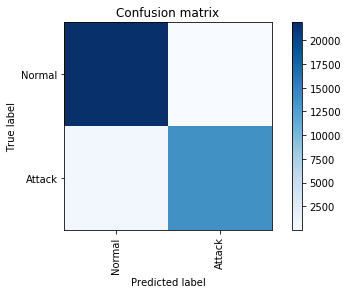

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     21942
           1       1.00      0.95      0.97     14454

   micro avg       0.98      0.98      0.98     36396
   macro avg       0.98      0.98      0.98     36396
weighted avg       0.98      0.98      0.98     36396



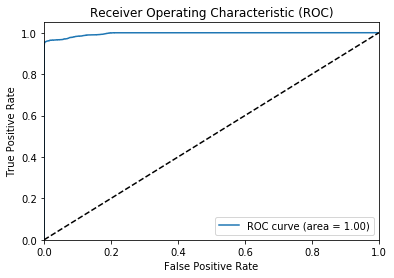

In [46]:
cnn_pred = model.predict(x_test_tf)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_cm = confusion_matrix(y_true, cnn_pred)
printmd("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_f1))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_true, cnn_pred))

cnn_pred = model.predict(x_test_tf)
cnn_pred = cnn_pred[:,1] # Only positive class (1)
plot_roc(cnn_pred,y_true)

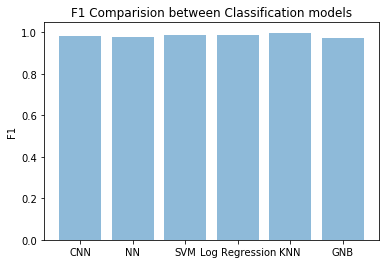

In [47]:
labels = ('CNN', 'NN', 'SVM', 'Log Regression', 'KNN', 'GNB')
y_pos = np.arange(len(labels))
measurement = [cnn_f1, nn_f1, svc_f1, logistic_f1, knn_f1, gnb_f1]

plt.bar(y_pos, measurement, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('F1')
plt.title('F1 Comparision between Classification models')

plt.show()

# Multi-class classification

We redefine the problem as a multi-class classification problem. We have 23 different outcomes for the output, 22 are classified as attack, and 1 is Normal connection

The data preprocessing is the same as binary classification problem above, however, the output will have 23 labels instead of binary. We want to see how our previous models perform in this multi-class classification problem.

In [48]:
df = pd.read_csv('network_intrusion_data.csv')
df.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]

In [49]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [50]:
df.shape

(494020, 42)

In [51]:
# df = df.loc[:, (df != 0).any(axis=0)] #drop columns with all 0
unique_val = df.apply(pd.Series.nunique)
cols_to_drop = unique_val[unique_val==1].index
df = df.drop(cols_to_drop, axis=1)

In [52]:
df.shape

(494020, 40)

In [53]:
df.drop_duplicates(keep='first', inplace=True)

In [54]:
df.shape

(145585, 40)

In [55]:
#from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler()

cols_to_normalize = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = scaler.fit_transform(df.select_dtypes(include=['float64','int64']))

numeric_features = pd.DataFrame(numeric_features, columns=cols_to_normalize)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [56]:
numeric_features.shape

(145585, 36)

In [57]:
scaler = preprocessing.LabelEncoder()

cols_to_encode = df.select_dtypes(include=['object']).columns
label_features = df.select_dtypes(include=['object']).apply(scaler.fit_transform)

label_features = pd.DataFrame(label_features, columns=cols_to_encode)

In [58]:
label_features.head()

,protocol_type,service,flag,outcome
0,1,22,9,11
1,1,22,9,11
2,1,22,9,11
3,1,22,9,11
4,1,22,9,11


In [59]:
label_features.drop(columns=['outcome'], inplace=True)

In [60]:
label_features.shape

(145585, 3)

In [61]:
numeric_features.reset_index(drop=True, inplace=True)
label_features.reset_index(drop=True, inplace=True)
input_data = pd.concat([numeric_features, label_features], axis=1)
input_data.shape

(145585, 39)

In [62]:
scaler = preprocessing.LabelEncoder()

output_data = scaler.fit_transform(df['outcome'])
output_data.shape

(145585,)

In [63]:
np.unique(output_data,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 array([  968,    30,     8,    53,    12,   651,    19,     9,     7,
        51820,   158, 87831,     3,     4,   206,   416,    10,   906,
          641,     2,   918,   893,    20], dtype=int64))

In [64]:
original_outcome = scaler.inverse_transform(output_data)
original_outcome = np.unique(original_outcome)
original_outcome

array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
       'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
       'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
       'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
       'warezclient.', 'warezmaster.'], dtype=object)

# Sklearn models for Multi-class classification

In [65]:
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=43)

In [67]:
# Initiate and train all the models
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(x_train, y_train)

svc = LinearSVC(dual=False)
svc.fit(x_train, y_train)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

gnb = GaussianNB()
gnb.fit(x_train, y_train)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GaussianNB(priors=None, var_smoothing=1e-09)

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------**Logistic Regression Report**---------------

F1 score: 0.9932021282992053
Confusion matrix: 
 [[  254     0     0     0     0     0     0     0     0     0     0    14
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     7     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     2     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   130     0     0     0     0     2    16
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     5     0     0     0     0     1
      0     0     0

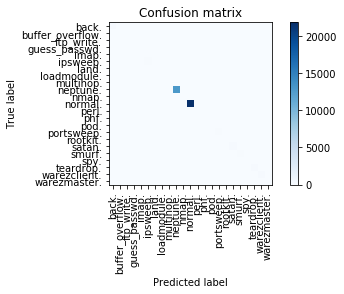

                  precision    recall  f1-score   support

           back.       0.98      0.95      0.96       268
buffer_overflow.       0.71      0.62      0.67         8
      ftp_write.       0.00      0.00      0.00         1
   guess_passwd.       0.88      1.00      0.93         7
           imap.       0.00      0.00      0.00         3
        ipsweep.       0.84      0.88      0.86       148
           land.       1.00      0.83      0.91         6
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     13017
           nmap.       0.62      0.18      0.28        45
         normal.       0.99      1.00      1.00     21862
           perl.       1.00      1.00      1.00         1
            phf.       0.50      1.00      0.67         2
            pod.       1.00      0.96      0.98        56
      portsweep.       0.92      0.82      0.87       118
        rootk

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
y_pred_Logistic = logreg.predict(x_test)
logistic_f1 = metrics.f1_score(y_test, y_pred_Logistic, average= "weighted")
logistic_cm = confusion_matrix(y_test, y_pred_Logistic)
printmd("-----------------**Logistic Regression Report**---------------")
print("F1 score: {}".format(logistic_f1))
print("Confusion matrix: \n", str(logistic_cm))
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(logistic_cm, original_outcome)
plt.show()

print(classification_report(y_test, y_pred_Logistic, target_names=original_outcome))

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------**SVM Report**---------------

F1 score: 0.9947093296224214
Confusion matrix: 
 [[  254     0     0     0     0     0     0     0     0     0     0    14
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     5     0     0     0     0     0     1     0     0     0     0
      0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     7     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   141     0     0     0     0     2     5
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     4     0     0     0     0     1
      0     0     0

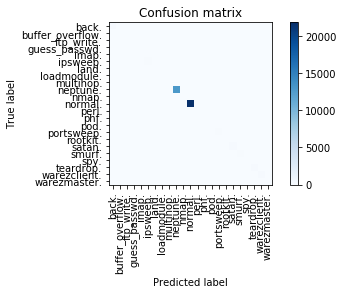

                  precision    recall  f1-score   support

           back.       1.00      0.95      0.97       268
buffer_overflow.       0.83      0.62      0.71         8
      ftp_write.       0.00      0.00      0.00         1
   guess_passwd.       0.78      1.00      0.88         7
           imap.       0.50      0.67      0.57         3
        ipsweep.       0.95      0.95      0.95       148
           land.       1.00      0.67      0.80         6
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     13017
           nmap.       0.76      0.42      0.54        45
         normal.       0.99      1.00      1.00     21862
           perl.       0.33      1.00      0.50         1
            phf.       1.00      1.00      1.00         2
            pod.       1.00      0.96      0.98        56
      portsweep.       0.96      0.88      0.92       118
        rootk

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
y_pred_svc = svc.predict(x_test)
svc_f1 = metrics.f1_score(y_test, y_pred_svc, average= "weighted")
svc_cm = confusion_matrix(y_test, y_pred_svc)
printmd("-----------------**SVM Report**---------------")
print("F1 score: {}".format(svc_f1))
print("Confusion matrix: \n", svc_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(svc_cm, original_outcome)
plt.show()

print(classification_report(y_test, y_pred_svc, target_names=original_outcome))

#plot_roc(y_pred_svc.astype(np.int), y_test.astype(np.int))

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------**KNN Report**---------------

F1 score: 0.9972511159694193
Confusion matrix: 
 [[  266     0     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     6     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     7     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   143     0     0     0     0     0     5
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     6     0     0     0     0     0
      0     0     0

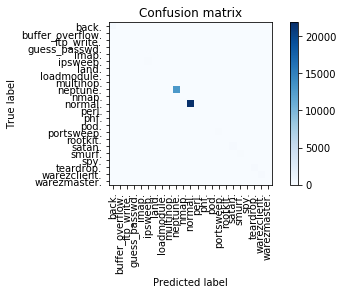

                  precision    recall  f1-score   support

           back.       0.99      0.99      0.99       268
buffer_overflow.       0.67      0.75      0.71         8
      ftp_write.       0.00      0.00      0.00         1
   guess_passwd.       0.88      1.00      0.93         7
           imap.       1.00      0.67      0.80         3
        ipsweep.       0.95      0.97      0.96       148
           land.       1.00      1.00      1.00         6
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     13017
           nmap.       1.00      0.80      0.89        45
         normal.       1.00      1.00      1.00     21862
           perl.       0.00      0.00      0.00         1
            phf.       0.00      0.00      0.00         2
            pod.       1.00      0.96      0.98        56
      portsweep.       0.99      0.88      0.93       118
        rootk

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
y_pred_knn = knn.predict(x_test)
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_cm = confusion_matrix(y_test, y_pred_knn)
printmd("-----------------**KNN Report**---------------")
print("F1 score: {}".format(knn_f1))
print("Confusion matrix: \n", knn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(knn_cm, original_outcome)
plt.show()

print(classification_report(y_test, y_pred_knn, target_names=original_outcome))

#plot_roc(y_pred_knn.astype(np.int), y_test.astype(np.int))

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------**Gaussian Naive Bayes Report**---------------

F1 score: 0.7638043035187312
Confusion matrix: 
 [[  268     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     2]
 [    0     0     1     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     7     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   148     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     5     0     0     0     0     1
      0     0     0

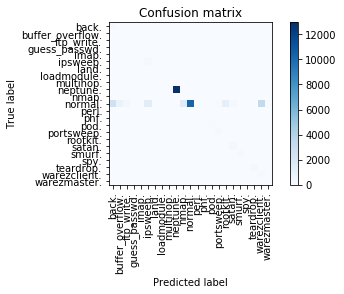

                  precision    recall  f1-score   support

           back.       0.09      1.00      0.17       268
buffer_overflow.       0.01      0.62      0.01         8
      ftp_write.       0.00      1.00      0.01         1
   guess_passwd.       1.00      1.00      1.00         7
           imap.       1.00      0.67      0.80         3
        ipsweep.       0.10      1.00      0.18       148
           land.       1.00      0.83      0.91         6
     loadmodule.       0.03      0.50      0.06         2
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     13017
           nmap.       0.01      0.36      0.02        45
         normal.       1.00      0.47      0.64     21862
           perl.       0.00      0.00      0.00         1
            phf.       1.00      0.50      0.67         2
            pod.       1.00      0.96      0.98        56
      portsweep.       0.58      0.87      0.70       118
        rootk

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
y_pred_gnb = gnb.predict(x_test)
gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average= "weighted")
gnb_cm = confusion_matrix(y_test, y_pred_gnb)
printmd("-----------------**Gaussian Naive Bayes Report**---------------")
print("F1 score: {}".format(gnb_f1))
print("Confusion matrix: \n", gnb_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(gnb_cm, original_outcome)
plt.show()

print(classification_report(y_test, y_pred_gnb, target_names=original_outcome))

#plot_roc(y_pred_gnb.astype(np.int), y_test.astype(np.int))

# Multi-class Classification Neural Network

In [72]:
scaler = preprocessing.LabelEncoder()
output_tf = scaler.fit_transform(df['outcome'])
output_tf

array([11, 11, 11, ..., 11, 11, 11])

In [73]:
output_tf.shape

(145585,)

In [74]:
tf_data = input_data.copy()
tf_data['outcome'] = output_tf
tf_data.shape

(145585, 40)

In [75]:
x, y = to_xy(tf_data, 'outcome')

In [76]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [77]:
print(x_train_tf.shape, y_train_tf.shape)

(109188, 39) (109188, 23)


In [78]:
checkpointer = ModelCheckpoint(filepath=".\multi.hdf5", verbose=0, save_best_only=True) # save best model
activation_func = ['relu', 'tanh']
optimizer_func = ['adam', 'sgd']

for i in range(2):
    for j in range(2):
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        #Build network
        model = Sequential()

        model.add(Dense(128, input_dim=x_train_tf.shape[1], activation=activation_func[i])) # Hidden 1     #  why input_dim=x.shape[1]?  
        model.add(Dropout(0.27))
        model.add(Dense(64, activation=activation_func[i])) # Hidden 2
        model.add(Dropout(0.27))
        model.add(Dense(32, activation=activation_func[i])) # Hidden 4
        model.add(Dense(y_train_tf.shape[1], activation='softmax')) # Output

        model.compile(loss='categorical_crossentropy', optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=1,epochs=1000, batch_size=512, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\multi.hdf5') # load weights from best model

**Activation** = relu  **Optimizer** = adam 

Train on 109188 samples, validate on 36397 samples
Epoch 1/1000
109188/109188 [==============================] - 2s 17us/step - loss: 0.5833 - acc: 0.8740 - val_loss: 0.0969 - val_acc: 0.9782
Epoch 2/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.1071 - acc: 0.9762 - val_loss: 0.0648 - val_acc: 0.9827
Epoch 3/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0744 - acc: 0.9807 - val_loss: 0.0407 - val_acc: 0.9877
Epoch 4/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0539 - acc: 0.9852 - val_loss: 0.0287 - val_acc: 0.9935
Epoch 5/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0409 - acc: 0.9899 - val_loss: 0.0243 - val_acc: 0.9947
Epoch 6/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0352 - acc: 0.9916 - val_loss: 0.0212 - val_acc: 0.9955
Epoch 7/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0306 - acc: 0.9931

**Activation** = relu  **Optimizer** = sgd 

Train on 109188 samples, validate on 36397 samples
Epoch 1/1000
109188/109188 [==============================] - 2s 17us/step - loss: 0.6646 - acc: 0.8505 - val_loss: 0.2842 - val_acc: 0.9544
Epoch 2/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.3123 - acc: 0.9495 - val_loss: 0.2243 - val_acc: 0.9576
Epoch 3/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.2531 - acc: 0.9553 - val_loss: 0.1872 - val_acc: 0.9618
Epoch 4/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.2190 - acc: 0.9588 - val_loss: 0.1638 - val_acc: 0.9682
Epoch 5/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1959 - acc: 0.9624 - val_loss: 0.1539 - val_acc: 0.9709
Epoch 6/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1808 - acc: 0.9656 - val_loss: 0.1395 - val_acc: 0.9740
Epoch 7/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1668 - acc: 0.9684 - va

**Activation** = tanh  **Optimizer** = adam 

Train on 109188 samples, validate on 36397 samples
Epoch 1/1000
109188/109188 [==============================] - 2s 20us/step - loss: 0.4464 - acc: 0.9078 - val_loss: 0.1364 - val_acc: 0.9724
Epoch 2/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.1135 - acc: 0.9782 - val_loss: 0.0882 - val_acc: 0.9818
Epoch 3/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0755 - acc: 0.9827 - val_loss: 0.0436 - val_acc: 0.9845
Epoch 4/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.0446 - acc: 0.9893 - val_loss: 0.0289 - val_acc: 0.9942
Epoch 5/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0339 - acc: 0.9928 - val_loss: 0.0231 - val_acc: 0.9955
Epoch 6/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0279 - acc: 0.9941 - val_loss: 0.0205 - val_acc: 0.9962
Epoch 7/1000
109188/109188 [==============================] - 1s 11us/step - loss: 0.0247 - acc: 0.9947

**Activation** = tanh  **Optimizer** = sgd 

Train on 109188 samples, validate on 36397 samples
Epoch 1/1000
109188/109188 [==============================] - 2s 17us/step - loss: 0.6722 - acc: 0.8780 - val_loss: 0.3161 - val_acc: 0.9568
Epoch 2/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.3088 - acc: 0.9551 - val_loss: 0.2699 - val_acc: 0.9575
Epoch 3/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.2632 - acc: 0.9572 - val_loss: 0.2407 - val_acc: 0.9576
Epoch 4/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.2371 - acc: 0.9584 - val_loss: 0.2194 - val_acc: 0.9577
Epoch 5/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.2187 - acc: 0.9593 - val_loss: 0.2005 - val_acc: 0.9585
Epoch 6/1000
109188/109188 [==============================] - 1s 10us/step - loss: 0.2023 - acc: 0.9608 - val_loss: 0.1865 - val_acc: 0.9623
Epoch 7/1000
109188/109188 [==============================] - 1s 9us/step - loss: 0.1907 - acc: 0.9622 

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_40 (Dense)             (None, 23)                759       
Total params: 16,215
Trainable params: 16,215
Non-trainable params: 0
_________________________________________________________________


-----------------**Fully-Connected Neural Network Report**---------------

F1 score: 0.997413755146767
Confusion matrix: 
 [[  267     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     6     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     2     0]
 [    0     1     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     7     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   143     0     0     0     0     2     3
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     6     0     0     0     0     0
      0     0     0 

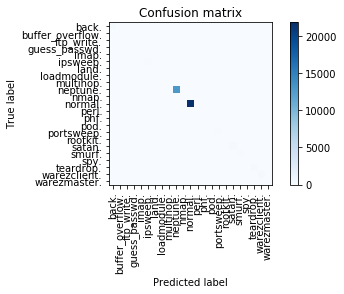

                  precision    recall  f1-score   support

           back.       0.99      1.00      0.99       268
buffer_overflow.       0.55      0.75      0.63         8
      ftp_write.       0.00      0.00      0.00         1
   guess_passwd.       1.00      1.00      1.00         7
           imap.       1.00      0.67      0.80         3
        ipsweep.       0.93      0.97      0.95       148
           land.       1.00      1.00      1.00         6
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     13017
           nmap.       0.92      0.73      0.81        45
         normal.       1.00      1.00      1.00     21862
           perl.       1.00      1.00      1.00         1
            phf.       1.00      0.50      0.67         2
            pod.       0.98      0.96      0.97        56
      portsweep.       1.00      0.97      0.99       118
        rootk

In [80]:
nn_pred = model.predict(x_test_tf)
nn_pred = np.argmax(nn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

nn_f1 = metrics.f1_score(y_true, nn_pred, average= "weighted")
nn_cm = confusion_matrix(y_true, nn_pred)
printmd("-----------------**Fully-Connected Neural Network Report**---------------")
print("F1 score: {}".format(nn_f1))
print("Confusion matrix: \n", nn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(nn_cm, original_outcome)
plt.show()

print(classification_report(y_true, nn_pred, target_names=original_outcome))


# Multi-class Classification CNN

In [81]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [82]:
# reshape the input into 4D array
x_train_tf = x_train_tf.reshape(x_train_tf.shape[0], 1, x_train_tf.shape[1], 1)
x_test_tf = x_test_tf.reshape(x_test_tf.shape[0], 1, x_test_tf.shape[1], 1)

In [83]:
print(x_train_tf.shape)
print(x_test_tf.shape)

(109188, 1, 39, 1)
(36397, 1, 39, 1)


In [84]:
y_train_tf.shape, y_test_tf.shape

((109188, 23), (36397, 23))

In [85]:
y_test_tf.dtype

dtype('float32')

In [86]:
checkpointer = ModelCheckpoint(filepath=".\multi_cnn.hdf5", verbose=0, save_best_only=True) # save best model
input_shape = (1, x_train_tf.shape[2], 1)
activation_func = ['relu', 'tanh']
optimizer_func = ['adam', 'sgd']

for i in range(2):
    for j in range(2):
        #Build network
        printmd("**Activation** = {}  **Optimizer** = {} ".format(activation_func[i], optimizer_func[j]))
        model = Sequential()

        model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                     activation=activation_func[i],
                     input_shape=input_shape))
        model.add(Conv2D(64, (1, 3), activation=activation_func[i]))
        model.add(MaxPooling2D(pool_size=(1, 2), strides=None))
        model.add(Dropout(0.25)) 
        model.add(Flatten())
        model.add(Dense(128, activation=activation_func[i]))
        model.add(Dropout(0.5))
        model.add(Dense(y_train_tf.shape[1], activation='softmax'))

        model.compile(loss="categorical_crossentropy", optimizer=optimizer_func[j], metrics=['accuracy'])

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=1,epochs=100, batch_size=512, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\multi_cnn.hdf5') # load weights from best model

**Activation** = relu  **Optimizer** = adam 

Train on 109188 samples, validate on 36397 samples
Epoch 1/100
109188/109188 [==============================] - 3s 24us/step - loss: 0.2032 - acc: 0.9585 - val_loss: 0.0425 - val_acc: 0.9910
Epoch 2/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0465 - acc: 0.9895 - val_loss: 0.0310 - val_acc: 0.9940
Epoch 3/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0366 - acc: 0.9920 - val_loss: 0.0256 - val_acc: 0.9954
Epoch 4/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0325 - acc: 0.9934 - val_loss: 0.0242 - val_acc: 0.9954
Epoch 5/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0289 - acc: 0.9940 - val_loss: 0.0224 - val_acc: 0.9961
Epoch 6/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0269 - acc: 0.9946 - val_loss: 0.0223 - val_acc: 0.9957
Epoch 7/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0244 - acc: 0.9949 - val_

**Activation** = relu  **Optimizer** = sgd 

Train on 109188 samples, validate on 36397 samples
Epoch 1/100
109188/109188 [==============================] - 2s 22us/step - loss: 0.6793 - acc: 0.8476 - val_loss: 0.2601 - val_acc: 0.9580
Epoch 2/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.2689 - acc: 0.9559 - val_loss: 0.1714 - val_acc: 0.9684
Epoch 3/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.2017 - acc: 0.9654 - val_loss: 0.1437 - val_acc: 0.9754
Epoch 4/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1707 - acc: 0.9707 - val_loss: 0.1277 - val_acc: 0.9765
Epoch 5/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1541 - acc: 0.9722 - val_loss: 0.1180 - val_acc: 0.9767
Epoch 6/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1436 - acc: 0.9726 - val_loss: 0.1086 - val_acc: 0.9768
Epoch 7/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1317 - acc: 0.9743 - val_

**Activation** = tanh  **Optimizer** = adam 

Train on 109188 samples, validate on 36397 samples
Epoch 1/100
109188/109188 [==============================] - 3s 24us/step - loss: 0.1436 - acc: 0.9713 - val_loss: 0.0317 - val_acc: 0.9909
Epoch 2/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0334 - acc: 0.9913 - val_loss: 0.0209 - val_acc: 0.9950
Epoch 3/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0251 - acc: 0.9934 - val_loss: 0.0173 - val_acc: 0.9953
Epoch 4/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0206 - acc: 0.9949 - val_loss: 0.0160 - val_acc: 0.9958
Epoch 5/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0188 - acc: 0.9953 - val_loss: 0.0143 - val_acc: 0.9966
Epoch 6/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0171 - acc: 0.9954 - val_loss: 0.0131 - val_acc: 0.9971
Epoch 7/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0163 - acc: 0.9960 - val_

**Activation** = tanh  **Optimizer** = sgd 

Train on 109188 samples, validate on 36397 samples
Epoch 1/100
109188/109188 [==============================] - 3s 23us/step - loss: 0.4612 - acc: 0.9388 - val_loss: 0.2395 - val_acc: 0.9581
Epoch 2/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.2273 - acc: 0.9591 - val_loss: 0.1840 - val_acc: 0.9581
Epoch 3/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.1831 - acc: 0.9636 - val_loss: 0.1523 - val_acc: 0.9676
Epoch 4/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1574 - acc: 0.9681 - val_loss: 0.1331 - val_acc: 0.9715
Epoch 5/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1405 - acc: 0.9706 - val_loss: 0.1186 - val_acc: 0.9723
Epoch 6/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1259 - acc: 0.9718 - val_loss: 0.1081 - val_acc: 0.9725
Epoch 7/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.1162 - acc: 0.9728 - val_

Epoch 59/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0376 - acc: 0.9897 - val_loss: 0.0289 - val_acc: 0.9920
Epoch 60/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0363 - acc: 0.9900 - val_loss: 0.0288 - val_acc: 0.9921
Epoch 61/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0368 - acc: 0.9899 - val_loss: 0.0285 - val_acc: 0.9922
Epoch 62/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0366 - acc: 0.9903 - val_loss: 0.0282 - val_acc: 0.9923
Epoch 63/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0366 - acc: 0.9902 - val_loss: 0.0282 - val_acc: 0.9923
Epoch 64/100
109188/109188 [==============================] - 2s 15us/step - loss: 0.0363 - acc: 0.9902 - val_loss: 0.0279 - val_acc: 0.9926
Epoch 65/100
109188/109188 [==============================] - 2s 14us/step - loss: 0.0361 - acc: 0.9900 - val_loss: 0.0278 - val_acc: 0.9925
Epoch 66/100


In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 1, 37, 32)         128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 35, 64)         6208      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 17, 64)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 1, 17, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1088)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               139392    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
__________

-----------------**Convolutional Neural Network Report**---------------

F1 score: 0.9972087673176286
Confusion matrix: 
 [[  267     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     6     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     1     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     7     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     2     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   144     0     0     0     0     0     2
      0     0     0     0     0     0     2     0     0     0     0]
 [    0     0     0     0     0     0     6     0     0     0     0     0
      0     0     0

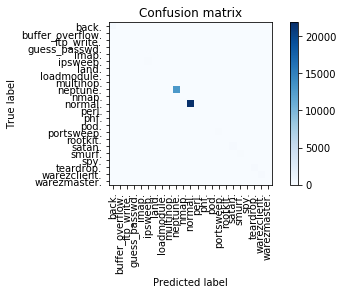

                  precision    recall  f1-score   support

           back.       0.99      1.00      0.99       268
buffer_overflow.       0.86      0.75      0.80         8
      ftp_write.       1.00      1.00      1.00         1
   guess_passwd.       1.00      1.00      1.00         7
           imap.       1.00      0.67      0.80         3
        ipsweep.       0.94      0.97      0.96       148
           land.       1.00      1.00      1.00         6
     loadmodule.       1.00      0.50      0.67         2
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     13017
           nmap.       1.00      0.73      0.85        45
         normal.       1.00      1.00      1.00     21862
           perl.       1.00      1.00      1.00         1
            phf.       1.00      0.50      0.67         2
            pod.       1.00      0.96      0.98        56
      portsweep.       1.00      0.97      0.98       118
        rootk

In [88]:
cnn_pred = model.predict(x_test_tf)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test_tf,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_cm = confusion_matrix(y_true, cnn_pred)
printmd("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_f1))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, original_outcome)
plt.show()

print(classification_report(y_true, cnn_pred, target_names=original_outcome))


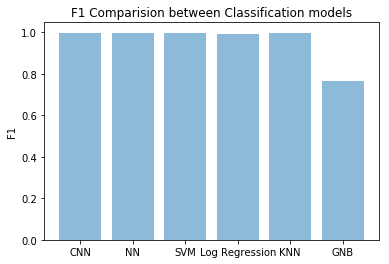

In [89]:
labels = ('CNN', 'NN', 'SVM', 'Log Regression', 'KNN', 'GNB')
y_pos = np.arange(len(labels))
measurement = [cnn_f1, nn_f1, svc_f1, logistic_f1, knn_f1, gnb_f1]

plt.bar(y_pos, measurement, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('F1')
plt.title('F1 Comparision between Classification models')

plt.show()